In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import math
import os
import pickle

import sys
sys.path.append('../code')
from path_utils import PATH_MONKEY_PROCESSED_DICT, PATH_TO_UNPROCESSED_DATA

In [2]:
params = {
   'axes.labelsize': 20,
   'legend.fontsize': 15,
   'xtick.labelsize': 20,
   'ytick.labelsize': 20,
   'text.usetex': False,
   'figure.figsize': [7,7],
   'font.size': 20,
    'lines.markersize':10
   }

plt.rcParams.update(params)

In [3]:
all_reach_dirs = np.asarray([0.00000000e+00 , 0.785398163, 1.57079633,
       2.35619449, 3.14159265, 3.92699082, 4.71238898,
       5.49778714])

In [4]:
import math as m
 
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
 
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
 
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

R_rot = Rx(m.pi/2)

In [5]:
PATH_TO_FIG = '/home/alessandro/Documents/github/DeepProprioception/figures/monkey_data1/'
    
save_flag = False

if save_flag:
    if not os.path.exists(PATH_TO_FIG):
        os.makedirs(PATH_TO_FIG)

### Load and visualize behavioral data

In [6]:
monkey_name = 'Snap'

## Path of old dataset
old_dataset_path = 'Snap_20190829_mod.pkl'
old_dataset_path = os.path.join(PATH_MONKEY_PROCESSED_DICT,old_dataset_path)

## Load data
a_file = open(old_dataset_path, "rb")
old_data = pickle.load(a_file)
a_file.close()

markers_names_all = ['Shoulder_JC', 'Marker_6', 'Pronation_Pt1', 'Marker_5', 'Marker_4', 'Marker_3', 'Marker_2', 'Marker_1']

In [7]:
## NEW DATASET UPD
print(old_data['trial_0'].keys())

marker3_b1 = []
marker6_b1 = []
joint_coords_b1 = []
# mus_jerk_b1 = []
for ii in range(len(old_data)): #770,777): #len(old_data)):
    marker3_tmp = old_data['trial_' + str(ii)]['endeffector_coords']
    marker6_tmp = old_data['trial_' + str(ii)]['marker6']
    joint_coords_tmp = old_data['trial_' + str(ii)]['joint_coords']
    
    marker3_b1.append(marker3_tmp)
    marker6_b1.append(marker6_tmp)
    joint_coords_b1.append(joint_coords_tmp)
marker3_b1 = np.hstack(marker3_b1).T
marker6_b1 = np.hstack(marker6_b1).T
joint_coords_b1 = np.hstack(joint_coords_b1).T

dict_keys(['muscle_len', 'muscle_vel', 'joint_coords', 'endeffector_coords', 'marker6'])


In [8]:
### Select a subset of joint data

subset = 1000

joint_angles_dataset = pd.DataFrame(joint_coords_b1[:subset,:], columns=['s_f', 's_a', 's_r', 'e_f'])

target_dir = np.ones_like(joint_coords_b1[:subset,0])

joint_angles_dataset['target_dir'] = target_dir

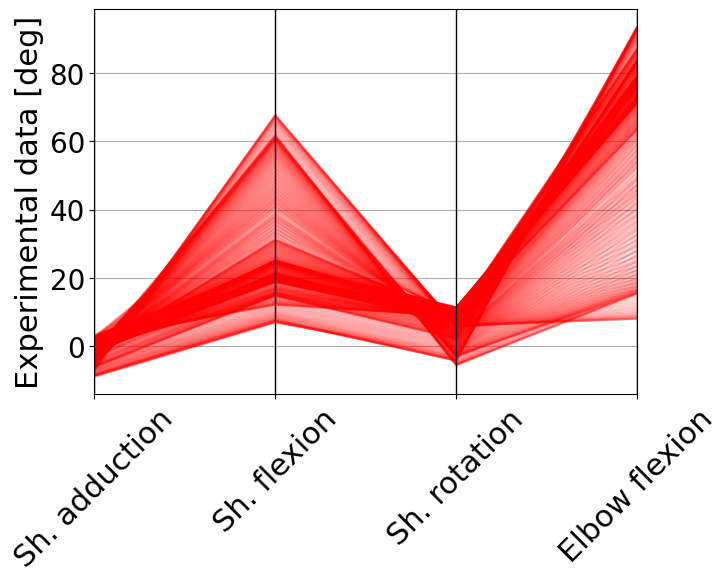

In [9]:
### Show all joints (flag_sel = 1) or only a subset (flag_sel = 0)
flag_sel = 0

from matplotlib import cm
def plot_par_coord(coord_df,flag_sel):

    #Some parameters
    if flag_sel == 1:
        sub_idx = np.arange(0,coord_df.shape[0],1) #(0,47)  #(0,40000,160)
    elif flag_sel == 0:
        sub_idx = np.arange(0,coord_df.shape[0],1)
        
    parallel_labels ={"s_a": r"$\theta_{s_a}$", 
                    "s_f": r"$\theta_{s_f}$",
                    "s_r": r"$\theta_{s_r}$", 
                    "e_f": r"$\theta_{e_f}$"}

    #Make figure
    fig, ax = plt.subplots(figsize=[7, 5]) #fig = 
    pd.plotting.parallel_coordinates(coord_df.loc[sub_idx],
                                class_column = 'target_dir',
                                cols= ['s_a', 's_f', 's_r', 'e_f'],
                                color='red',
                                # colormap = cm.get_cmap('Spectral'), #[[1,0,0,0.2],[0,1,0,0.5],[0,0,1,0.7],[1,1,1,0.9]]
                                alpha = 0.1,
#                                 title = 'Parallel joint coordinates' 
                                )
    plt.ylabel('Experimental data [deg]',fontsize=22)
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.get_legend().remove()
    ax.set_xticklabels(['Sh. adduction','Sh. flexion', 'Sh. rotation', 'Elbow flexion'], rotation=45,fontsize=22)
#     fig.show()

plot_par_coord(joint_angles_dataset,flag_sel)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'joint_angles_par.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angles_par.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angles_par.svg', format='svg', dpi=1200, bbox_inches='tight')

### Parallel coordinates for synthetic data

In [10]:
##### Select folder:
folder = [4019]

maxx = 0
all_endeff = []
all_traj = []
all_muscle = []
all_vel = []
all_mus_jerk = []
labels = []
labels1 = []
len_traj = []
all_marker6 = []

for j in folder: #range(101,121,1): #121
    path = PATH_TO_UNPROCESSED_DATA + '/' + str(j) + '/'
    
    for i in range(1,41,1):  #40
        path_file = path + str(i) + '.p'
        file = open(path_file, "rb" )
        traj_set = pickle.load(file)
        file.close()

        lab_count = 0
        for ii in range(len(traj_set[0])):
            traj = traj_set[0][ii]
        
            endeff_tmp = traj['endeffector_coords']
            marker6_tmp = traj['marker6']
            traj_tmp = traj['joint_coords']
            muscle_tmp = traj['muscle_coords']
            mus_jerk_tmp = traj['muscle_jerk']
            lab_tmp = traj['label']

            vel_tmp = np.gradient(muscle_tmp,0.010,axis=1)
            if np.shape(traj_tmp)[1] > maxx:
                maxx = np.shape(traj_tmp)[1]

            lab_count += 1
            len_traj.append(endeff_tmp.shape[1])
            all_traj.append(traj_tmp)
            all_endeff.append(endeff_tmp)
            all_muscle.append(muscle_tmp)
            all_vel.append(vel_tmp)
            labels.append(np.full(len(traj_set),lab_tmp))
            labels1.append(np.full(np.shape(traj_tmp)[1],lab_tmp))
            all_mus_jerk.append(mus_jerk_tmp)
            all_marker6.append(marker6_tmp)
            
labels = np.hstack(labels)
labels1 = np.hstack(labels1)
endeff_coord = np.hstack(all_endeff) #all_endeff[0]
joint_coords = np.hstack(all_traj) #all_traj[0]
muscle_len = np.hstack(all_muscle)
muscle_vel = np.hstack(all_vel)
muscle_jerk = np.hstack(all_mus_jerk)
len_traj = np.hstack(len_traj)
marker6 = np.hstack(all_marker6)

print('Num of trajectories: ',len(all_traj))
print('Num of time points: ',len(labels1))

Num of trajectories:  5716
Num of time points:  630861


In [18]:
# Dataframe of INITIAL end-effector location 
angle_labels = ['s_f', 's_a', 's_r', 'e_f']

coord_df = pd.DataFrame(columns = angle_labels + ['x','y','z', 'muscle_len', 'muscle_vel', 'label'])
for idx, angle in zip(range(4), angle_labels):
    coord_df[angle] = joint_coords[idx,:]
    
coord_df['label'] = labels1

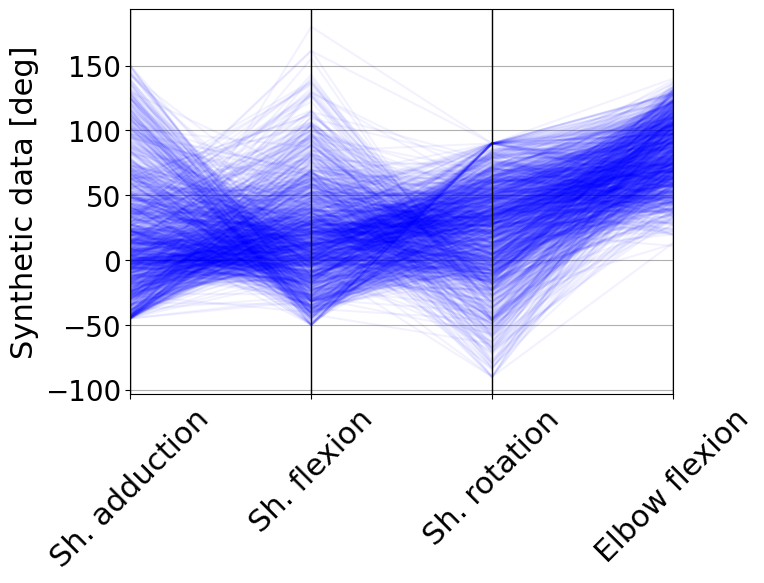

In [19]:
### Show all joints (flag_sel = 1) or only a subset (flag_sel = 0)
flag_sel = 0

from matplotlib import cm
def plot_par_coord(coord_df,flag_sel):

    #Some parameters
    if flag_sel == 1:
        sub_idx = np.arange(0,coord_df.shape[0],1) #(0,47)  #(0,40000,160)
    elif flag_sel == 0:
        sub_idx = np.arange(0,coord_df.shape[0],500)
        
    parallel_labels ={"s_a": r"$\theta_{s_a}$", 
                    "s_f": r"$\theta_{s_f}$",
                    "s_r": r"$\theta_{s_r}$", 
                    "e_f": r"$\theta_{e_f}$"}

    #Make figure
    fig, ax = plt.subplots(figsize=[7, 5]) #fig = 
    pd.plotting.parallel_coordinates(coord_df.loc[sub_idx],
                                class_column = 'label',
                                cols= ['s_a', 's_f', 's_r', 'e_f'],
                                color = 'blue',
                                # colormap = cm.get_cmap('Spectral'), #[[1,0,0,0.2],[0,1,0,0.5],[0,0,1,0.7],[1,1,1,0.9]]
                                alpha = 0.05,
#                                 title = 'Parallel joint coordinates' 
                                )
    ax.get_legend().remove()
    # plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    plt.ylabel('Synthetic data [deg]',fontsize=22)
    ax.set_xticklabels(['Sh. adduction','Sh. flexion', 'Sh. rotation', 'Elbow flexion'], rotation=45,fontsize=22)
#     fig.show()

plot_par_coord(coord_df,flag_sel)

if save_flag:
    plt.savefig(PATH_TO_FIG + 'joint_angles_par_pcr.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angles_par_pcr.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'joint_angles_par_pcr.svg', format='svg', dpi=1200, bbox_inches='tight')

### End-effector comparison

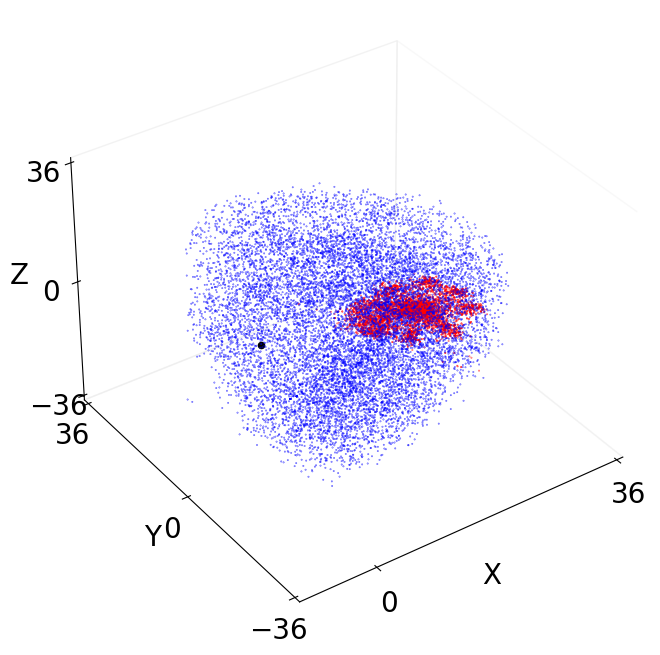

In [20]:
subsel3 = [ii for ii in range(0,len(marker3_b1),50)]
subsel1 = [ii for ii in range(0,endeff_coord.shape[1],50)]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
#notebook

view = 'xyz'

grid_resolution = 2   # in cm

xmax, xmin = 36, -10    # forward and backward
ymax, ymin = 36, -36  # left and right
zmax, zmin = 36, -36  # up and down

X = np.linspace(xmin, xmax, (xmax - xmin)//grid_resolution + 1)
Y = np.linspace(ymin, ymax, (ymax - ymin)//grid_resolution + 1)
Z = np.linspace(zmin, zmax, (zmax - zmin)//grid_resolution + 1)
x, y = np.meshgrid(Y, Z)

ax = plt.figure(figsize=[8, 8]).gca(projection='3d')
ax.scatter(marker3_b1[subsel3, 0], marker3_b1[subsel3, 1], marker3_b1[subsel3, 2], s=0.1, alpha=0.8, color='red', label = 'Monkey')
# ax.scatter(all_endeffstack[subsel, 0], all_endeffstack[subsel, 1], all_endeffstack[subsel, 2], s=0.1, alpha=0.8, color='red')
# ax.scatter(startpts_all[:, 0], startpts_all[:, 1], startpts_all[:, 2], s=0.1, alpha=0.8, color='blue')
ax.scatter([0], [0], [0], color='black')
ax.scatter(0, 0, 0, s=3, color='black') #900

ax.scatter(endeff_coord[0,subsel1], endeff_coord[1,subsel1], endeff_coord[2,subsel1], s=0.1, alpha=0.8, color='blue')

ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False

if view == 'xz':
    ax.view_init(elev=0, azim=-90)
if view == 'xy':
    ax.view_init(elev=90, azim=-90)
if view == 'xyz':
    ax.view_init(elev=35, azim=-125)

ax.grid(False)
ax.set_xticks([0, 36]); ax.set_yticks([-36, 0, 36]); ax.set_zticks([-36, 0, 36]) #before
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

if save_flag:
    plt.savefig(PATH_TO_FIG + 'endeff_and_monkey_ee_'+view+'.png', format='png', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'endeff_and_monkey_ee_'+view+'.pdf', format='pdf', dpi=1200, bbox_inches='tight')
    plt.savefig(PATH_TO_FIG + 'endeff_and_monkey_ee_'+view+'.svg', format='svg', dpi=1200, bbox_inches='tight')
